In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import lightgbm as lgbm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
cd drive/My Drive/GCI2020/final_task/

/content/drive/My Drive/GCI2020/final_task


In [ ]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [ ]:
train = pd.read_csv('./input/application_train.csv')
test = pd.read_csv('./input/application_test.csv')
description = pd.read_csv('./input/HomeCredit_columns_description.csv')

In [ ]:
print(train['TARGET'].value_counts())
print(train['TARGET'].value_counts().to_list() / np.sum(train['TARGET'].value_counts().to_list()) * 100)

0    282686
1     24825
Name: TARGET, dtype: int64
[91.92711805  8.07288195]


In [ ]:
description.rename(columns={'Unnamed: 0':'index'}, inplace=True)
description['Table'].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [ ]:
description_app = description[description['Table']=='application_{train|test}.csv']

In [ ]:
def print_description(description):
    for des in description.values:
        print("{}: {}".format(des[2], des[4]))

In [ ]:
print_description(description_app)

SK_ID_CURR: サンプルのローンのID
TARGET: 対象変数（1-支払い困難な顧客：我々のサンプルでは、最初のY回のローンの少なくとも1回の分割払いでX日以上の支払い遅延があった、0-その他のすべてのケース）。
NAME_CONTRACT_TYPE: ローンが現金かリボルビングかの識別
CODE_GENDER: クライアントの性別
FLAG_OWN_CAR: クライアントが車を所有している場合のフラグ
FLAG_OWN_REALTY: クライアントが家やアパートを所有しているかどうかのフラグ
CNT_CHILDREN: クライアントの子供の数
AMT_INCOME_TOTAL: クライアントの収入
AMT_CREDIT: 融資の与信額
AMT_ANNUITY: ローン年金
AMT_GOODS_PRICE: 消費者金融の場合は、融資を受けるための商品の価格です。
NAME_TYPE_SUITE: 融資を申し込む際に同行していたのは誰だったのか
NAME_INCOME_TYPE: クライアントの収入タイプ（サラリーマン、社会人、産休、...
NAME_EDUCATION_TYPE: クライアントが達成した最高学歴のレベル
NAME_FAMILY_STATUS: クライアントの家族状況
NAME_HOUSING_TYPE: ご依頼者様の住宅事情（賃貸、親と同居、...)
REGION_POPULATION_RELATIVE: クライアントが住む地域の正規化された人口（数値が高いほど、クライアントはより人口の多い地域に住んでいることを意味する
DAYS_BIRTH: お申し込み時のご依頼者様の年齢（日単位
DAYS_EMPLOYED: 申請の何日前に現在の雇用を開始したか
DAYS_REGISTRATION: 申請の何日前にクライアントが登録を変更したか
DAYS_ID_PUBLISH: 申し込みの何日前に、クライアントは融資を申し込んだ本人確認書類を変更しました。
OWN_CAR_AGE: お客様のお車の年齢
FLAG_MOBIL: 携帯電話を提供したか（1=はい、0=いいえ
FLAG_EMP_PHONE: クライアントが仕事用の電話を提供したか（1=はい、0=いいえ
FLAG_WORK_PHONE: 自宅の電話を提供したか（1=はい、0=いいえ
FLAG_C

In [ ]:
# fontsizeの設定
plt.rcParams["font.size"] = 14

# サイズの設定
plt.rcParams['figure.figsize'] = (15.0, 6.0)

In [ ]:
def one_hot_encoding(df):
    
    return_df = pd.get_dummies(df, drop_first=True)
    
    return return_df

In [ ]:
def to_add_feature(df):
    
    df['EXT_123_mean'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']) / 3
    df['EXT_23_mean'] = (df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']) / 2
    df['EXT_12_mean'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_2']) / 2
    df['EXT_13_mean'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_3']) / 2
    df['EXT_23_sabun'] = abs(df['EXT_SOURCE_2'] - df['EXT_SOURCE_3'])
    df['EXT_12_sabun'] = abs(df['EXT_SOURCE_1'] - df['EXT_SOURCE_2'])
    df['EXT_13_sabun'] = abs(df['EXT_SOURCE_1'] - df['EXT_SOURCE_3'])
    
    # leakとなりうる部分はコメントアウト
    # df['CREDIT_ANNUITY'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    # df['CREDIT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    # df['INCOME_TOTAL_CREDIT'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    
    df['INCOME_TOTAL_ANNUITY'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['DAYS_BIRTH_365_OWN_CAR_AGE'] = (df['DAYS_BIRTH'] / 365) - df['OWN_CAR_AGE']
    df['DATS_BIRTH_EMPLOYED'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    return df

In [ ]:
featured_df = to_add_feature(train)

In [ ]:
assert featured_df.shape[1] == 132

In [ ]:
onehoted_df = one_hot_encoding(featured_df)

In [ ]:
assert onehoted_df.shape[0] == train.shape[0]

In [ ]:
display(onehoted_df)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,...,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.00

In [ ]:
target_0_df = onehoted_df[onehoted_df['TARGET']==0]
target_1_df = onehoted_df[onehoted_df['TARGET']==1]

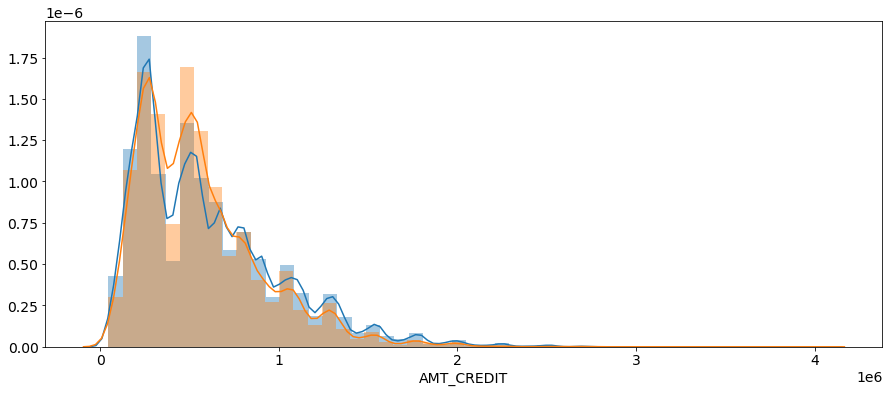

In [ ]:
sns.distplot(target_0_df['AMT_CREDIT'], bins=50)
sns.distplot(target_1_df['AMT_CREDIT'], bins=50)

In [ ]:
shuffled_target_0_df = target_0_df.sample(frac=1, random_state=71).reset_index(drop=True)

In [ ]:
train_df = shuffled_target_0_df[shuffled_target_0_df.index < 257861].reset_index()
test_df = shuffled_target_0_df[shuffled_target_0_df.index > 257860]
test_df = pd.concat([test_df, target_1_df], axis=0).reset_index()

In [ ]:
display(train_df, test_df)

,index,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,...,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0,401351,0,0,225000.0,720000.0,36000.0,720000.0,0.035792,-16916,NaN,-377.0,-462,4.0,1,0,0,1,0,0,2.0,2,2,16,0,0,0,0,0,0,NaN,0.587974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

,index,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,...,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,257861,370826,0,0,247500.0,204858.0,10588.5,171000.0,0.018850,-14758,-3091.0,-815.0,-2933,NaN,1,1,0,1,0,0,2.0,2,2,10,0,0,0,0,0,0,0.696719,0.710723,0.288130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0

In [ ]:
train_X = train_df.drop(columns=['index', 'TARGET', 'SK_ID_CURR', 'AMT_CREDIT'])
train_y = train_df['AMT_CREDIT']
test_X = test_df.drop(columns=['index', 'TARGET', 'SK_ID_CURR', 'AMT_CREDIT'])
test_y = test_df['AMT_CREDIT']

In [ ]:
X = train_X.values
y = train_y.values

In [ ]:
fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(X, y))

In [ ]:
def fit_lgbm(train_X, train_y, CV, params: dict=None, verbose=100):
    
    oof_preds = np.zeros(X.shape[0])

    if params is None:
        params = {}

    models = []

    score_list = []

    for i, (idx_train, idx_valid) in enumerate(CV):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params, random_state=71, n_estimators=10000)
        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)], 
                early_stopping_rounds=100, 
                eval_metric='rmse',
                verbose=verbose)
          
        models.append(clf)
        oof_preds[idx_valid] = clf.predict(x_valid, num_iteration=clf.best_iteration_)
        print('Fold %2d RMSE : %.6f' % (i + 1, np.sqrt(mean_squared_error(y_valid, oof_preds[idx_valid]))))
    
    score = np.sqrt(mean_squared_error(y, oof_preds))
    print('Full RMSE score %.6f' % score)
    return oof_preds, models

In [ ]:
oof, models = fit_lgbm(train_X, train_y, CV=cv)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 44013	valid_0's l2: 1.93714e+09
[200]	valid_0's rmse: 42623.4	valid_0's l2: 1.81675e+09
[300]	valid_0's rmse: 41984.7	valid_0's l2: 1.76272e+09
[400]	valid_0's rmse: 41362.8	valid_0's l2: 1.71088e+09
[500]	valid_0's rmse: 40815.4	valid_0's l2: 1.6659e+09
[600]	valid_0's rmse: 40226.8	valid_0's l2: 1.6182e+09
[700]	valid_0's rmse: 39955.6	valid_0's l2: 1.59645e+09
[800]	valid_0's rmse: 39649.2	valid_0's l2: 1.57206e+09
[900]	valid_0's rmse: 39120.2	valid_0's l2: 1.53039e+09
[1000]	valid_0's rmse: 39064.4	valid_0's l2: 1.52603e+09
[1100]	valid_0's rmse: 38761.7	valid_0's l2: 1.50247e+09
[1200]	valid_0's rmse: 38656.2	valid_0's l2: 1.4943e+09
[1300]	valid_0's rmse: 38488.5	valid_0's l2: 1.48136e+09
[1400]	valid_0's rmse: 38370.3	valid_0's l2: 1.47228e+09
[1500]	valid_0's rmse: 38321.3	valid_0's l2: 1.46852e+09
[1600]	valid_0's rmse: 38208.6	valid_0's l2: 1.4599e+09
[1700]	valid_0's rmse: 38076.7	valid_0's

In [ ]:
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index

    fig, ax = plt.subplots(figsize=(len(order) * .4, 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    fig.tight_layout()
    return fig, ax

(<Figure size 6825.6x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f487618e710>)

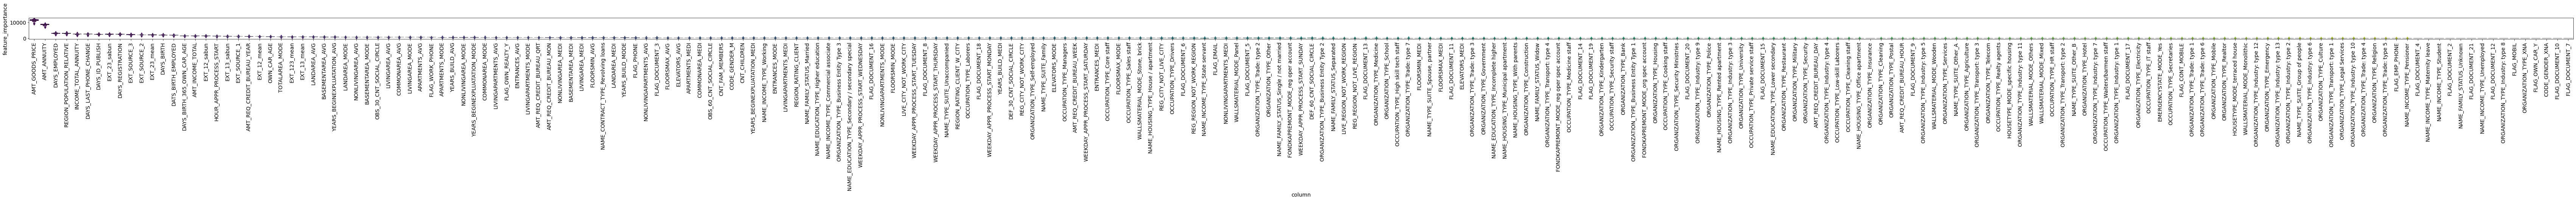

In [ ]:
visualize_importance(models, train_X)

In [ ]:
pred = np.array([model.predict(test_X.values) for model in models])
pred = np.mean(pred, axis=0)

In [ ]:
print(np.sqrt(mean_squared_error(test_y.values, pred)))

37124.02694266485


In [ ]:
zikken_df = test_df[['index', 'SK_ID_CURR', 'TARGET', 'AMT_CREDIT']]
zikken_df['PRED'] = pred
zikken_df['PRED_SABUN'] = zikken_df['AMT_CREDIT'] - zikken_df['PRED']
display(zikken_df)

,index,SK_ID_CURR,TARGET,AMT_CREDIT,PRED,PRED_SABUN
0,257861,370826,0,204858.0,2.150044e+05,-10146.366100
1,257862,424117,0,83538.0,8.328119e+04,256.812748
2,257863,162360,0,716148.0,6.349695e+05,81178.518180
3,257864,106168,0,273636.0,2.692738e+05,4362.243274
4,257865,248470,0,286704.0,2.875863e+05,-882.270794
...,...,...,...,...,...,...
49645,307448,456186,1,450000.0,4.953394e+05,-45339.379800
49646,307475,456215,1,1303200.0,1.207696e+06,95504.117372
49647,307481,456225,1,297000.0,3.632431e+05,-66243.055263
49648,307489,456233,1,521280.0,5.117428e+05,9537.158806


In [ ]:
# zikken_df.to_csv('zikken_df.csv', index=False)

In [ ]:
# zikken_df = pd.read_csv('zikken_df.csv')

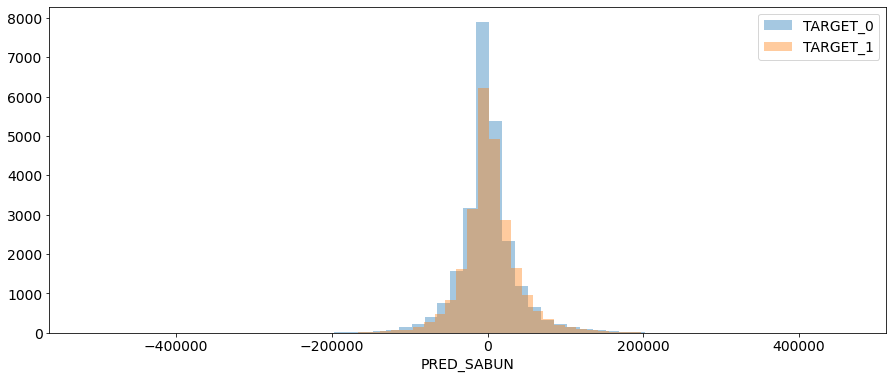

In [ ]:
sns.distplot(zikken_df[zikken_df['TARGET']==0]['PRED_SABUN'], label='TARGET_0', kde=False)
sns.distplot(zikken_df[zikken_df['TARGET']==1]['PRED_SABUN'], label='TARGET_1', kde=False)
plt.legend()

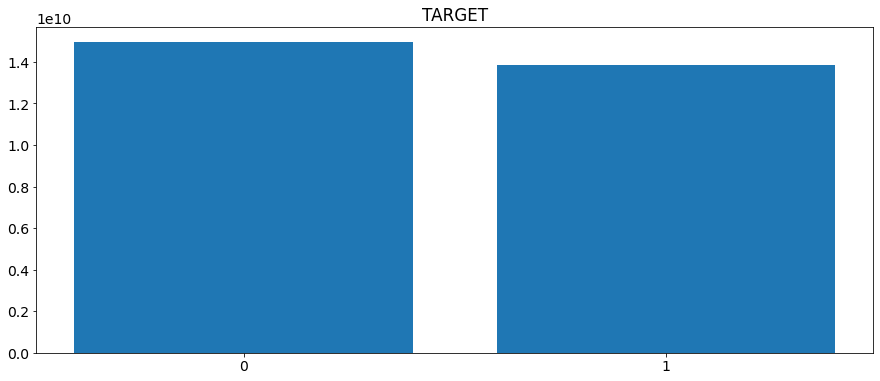

In [ ]:
plt.figure()
plt.bar(["0", "1"], [zikken_df[zikken_df['TARGET']==0]['AMT_CREDIT'].sum(), zikken_df[zikken_df['TARGET']==1]['AMT_CREDIT'].sum()])
plt.title('TARGET')
plt.show()

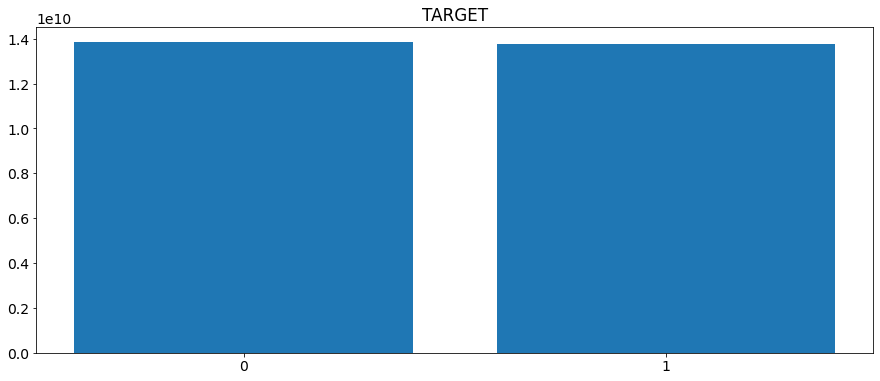

In [ ]:
plt.figure()
plt.bar(["0", "1"], [zikken_df[zikken_df['TARGET']==1]['AMT_CREDIT'].sum(), zikken_df[zikken_df['TARGET']==1]['PRED'].sum()])
plt.title('TARGET')
plt.show()

In [ ]:
zikken_df['PRED_SABUN'].sum()

96986362.64957361

In [ ]:
zikken_df[zikken_df['TARGET']==1]['AMT_CREDIT'].sum()

13846851949.5

In [ ]:
zikken_df[zikken_df['TARGET']==1]['PRED'].sum()

13758105320.202818

In [ ]:
print(len(zikken_df[(zikken_df['PRED_SABUN']>0) & (zikken_df['TARGET']==1)]['PRED_SABUN']), len(zikken_df[(zikken_df['PRED_SABUN']<0) & (zikken_df['TARGET']==1)]['PRED_SABUN']))

13050 11775


In [ ]:
print(zikken_df[(zikken_df['PRED_SABUN']>0) & (zikken_df['TARGET']==1)]['PRED_SABUN'].sum(), zikken_df[(zikken_df['PRED_SABUN']<0) & (zikken_df['TARGET']==1)]['PRED_SABUN'].sum())

352908765.889793 -264162136.5926111


In [ ]:
zikken_df[zikken_df['TARGET']==1]['PRED_SABUN'].sum()

88746629.29718187

In [ ]:
zikken_df[zikken_df['TARGET']==0]['AMT_CREDIT'].sum()

14950722154.5

In [ ]:
zikken_df[zikken_df['TARGET']==0]['PRED'].sum()

14942482421.14761

In [ ]:
print(len(zikken_df[(zikken_df['PRED_SABUN']>0) & (zikken_df['TARGET']==0)]['PRED_SABUN']), len(zikken_df[(zikken_df['PRED_SABUN']<0) & (zikken_df['TARGET']==0)]['PRED_SABUN']))

12064 12761


In [ ]:
print(zikken_df[(zikken_df['PRED_SABUN']>0) & (zikken_df['TARGET']==0)]['PRED_SABUN'].sum(), zikken_df[(zikken_df['PRED_SABUN']<0) & (zikken_df['TARGET']==0)]['PRED_SABUN'].sum())

303866349.4897525 -295626616.13736075


In [ ]:
zikken_df[zikken_df['TARGET']==0]['PRED_SABUN'].sum()

8239733.352391725

In [ ]:
!pip install japanize_matplotlib
import japanize_matplotlib

     |████████████████████████████████| 4.1MB 2.8MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120191 sha256=b2633e726a05970c501ccdf12820e711d275e815f8b1ec012bb6f89bee16ba9c
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


In [ ]:
# fontsizeの設定
plt.rcParams["font.size"] = 14

# サイズの設定
plt.rcParams['figure.figsize'] = (12.0, 4.0)

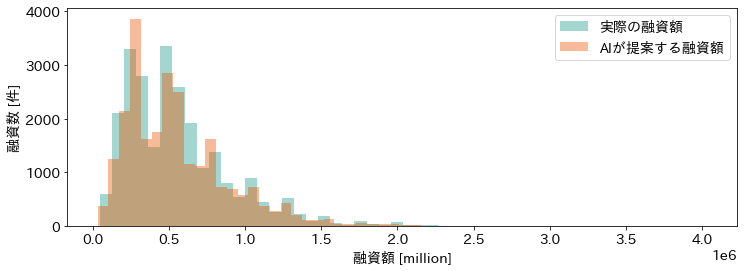

In [ ]:
# plt.title('債務不履行における融資額と融資数の関係')
sns.distplot(zikken_df[zikken_df['TARGET']==1]['AMT_CREDIT'], label='実際の融資額', kde=False, color='#1a9988')
sns.distplot(zikken_df[zikken_df['TARGET']==1]['PRED'], label='AIが提案する融資額', kde=False, color='#eb5600')
plt.xlabel('融資額 [million]')
plt.ylabel('融資数 [件]')
plt.legend()

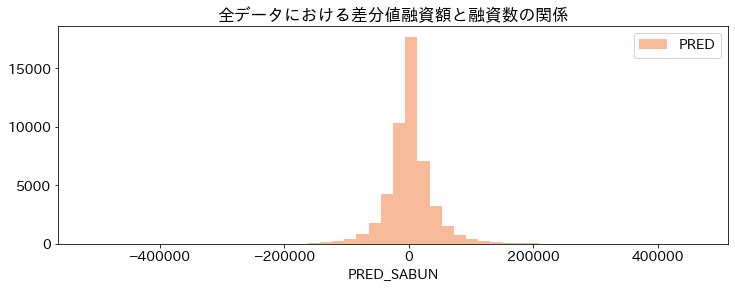

In [ ]:
plt.title('全データにおける差分値融資額と融資数の関係')
sns.distplot(zikken_df['PRED_SABUN'], label='PRED', kde=False, color='#eb5600')
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

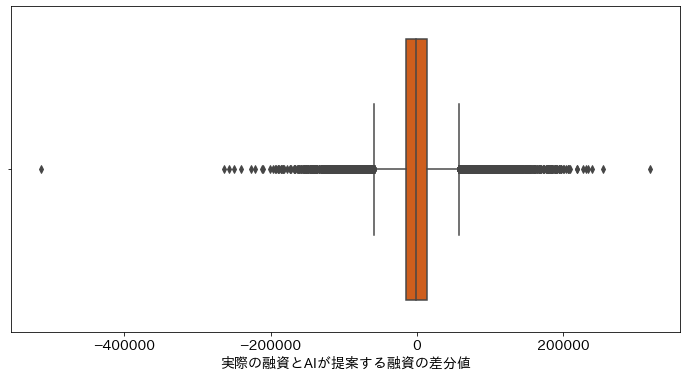

In [ ]:
sns.boxplot(zikken_df[zikken_df['TARGET']==0]['PRED_SABUN'], color='#eb5600')
plt.xlabel('実際の融資とAIが提案する融資の差分値')
plt.show()

In [ ]:
zikken_df[zikken_df['TARGET']==0][['PRED_SABUN']].describe()

,PRED_SABUN
count,24825.000000
mean,331.912723
std,37301.240604
min,-513910.244635
25%,-15114.100793
50%,-468.063622
75%,13976.852289
max,318796.132172


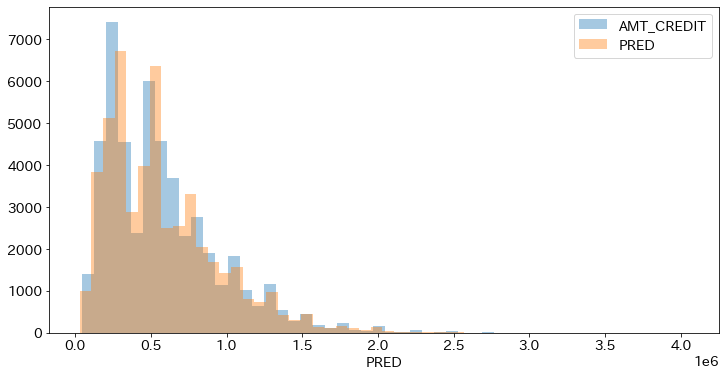

In [ ]:
sns.distplot(zikken_df['AMT_CREDIT'], label='AMT_CREDIT', kde=False)
sns.distplot(zikken_df['PRED'], label='PRED', kde=False)
plt.legend()

In [ ]:
zikken_df.describe()

,index,SK_ID_CURR,TARGET,AMT_CREDIT,PRED,PRED_SABUN
count,49650.000000,49650.000000,49650.000000,4.965000e+04,4.965000e+04,49650.000000
mean,211697.834582,277689.868520,0.500000,5.800116e+05,5.780582e+05,1953.401060
std,85823.983878,102528.174484,0.500005,3.782883e+05,3.754448e+05,37072.972401
min,0.000000,100002.000000,0.000000,4.500000e+04,2.993929e+04,-513910.244635
25%,152101.000000,189056.250000,0.000000,2.762775e+05,2.761322e+05,-14395.479749
50%,261500.500000,277725.500000,0.500000,5.084955e+05,5.077630e+05,229.839517
75%,272994.750000,365999.000000,1.000000,7.819200e+05,7.748601e+05,16644.207243
max,307509.000000,456254.000000,1.000000,4.050000e+06,3.872714e+06,463658.458893
